<a href="https://colab.research.google.com/github/LYULU2/covid-vaccine-misinformation/blob/master/Data_Cleaning_and_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount("/content/drive")

Found GPU at: /device:GPU:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import string
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_alt_before = pd.read_csv('/content/drive/MyDrive/Alt-right-2018-01-01--2020-02-29.csv', delimiter=',')
data_anti_before = pd.read_csv('/content/drive/MyDrive/AVaxxer-2018-01-01--2020-02-29.csv', delimiter=',')
data_alt_after = pd.read_csv('/content/drive/MyDrive/Alt-right-2020-03-01--2021-09-19.csv', delimiter=',')
data_anti_after = pd.read_csv('/content/drive/MyDrive/AVaxxer-2020-03-01--2021-09-19.csv', delimiter=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data_alt_after.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'Likes at Posting', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry',
       'Care', 'Video Share Status', 'Is Video Owner?', 'Post Views',
       'Total Views', 'Total Views For All Crossposts', 'Video Length', 'URL',
       'Message', 'Link', 'Final Link', 'Image Text', 'Link Text',
       'Description', 'Sponsor Id', 'Sponsor Name', 'Sponsor Category',
       'Overperforming Score (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )'],
      dtype='object')

## Extract Hashtags

In [ ]:
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def extract_hashtags(data):
    data['Message'] = data['Message'].fillna('')
    data['Message'] = data['Message'].astype('string')
    data['hashtags'] = data.Message.apply(find_hashtags)
    hashtags_list_df = data.loc[
                       data.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
    flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
    top_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
    return top_hashtags                                        

In [ ]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [ ]:
flattened_hashtags_df.groupby(['hashtag']).size().reset_index().\
    rename(columns={0:'count'})

,hashtag,records
0,#ALegendInHisOwnTime,1
1,#AOCLied,2
2,#AReckoningIsComing,1
3,#ARiseUSA,1
4,#Adada2021,1
...,...,...
486,#wipeitdownchallenge,1
487,#woke,1
488,#worldwide,1
489,#worship,1


### results for top hashtag extraction

In [ ]:
extract_hashtags(data_alt_before)

,hashtag,counts
0,#SmartEagles,18
1,#DrainTheSwamp,13
2,#Trump2020,13
3,#Truth,11
4,#Smarteagles2019,7
...,...,...
331,#MyFathersDaughter,1
332,#NOKAP,1
333,#NathanBedfordForrestBoyhoodHome,1
334,#NeverTrumpers,1


In [ ]:
top_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
top_hashtags                                        

,hashtag,counts
0,#TNIC,27
1,#TEXIT,24
2,#SmartEagles2020,16
3,#SCV4,16
4,#SCV,16
...,...,...
486,#China,1
487,#SALVATION,1
488,#S3599,1
489,#RussiaGate,1


In [ ]:
extract_hashtags(data_anti_before)

,hashtag,counts
0,#CDCwhistleblower,1790
1,#ChildrensHealthDefense,1638
2,#InformedConsent,1500
3,#Vaccines,1369
4,#Science,1212
...,...,...
9657,#SA301,1
9658,#S3899,1
9659,#S2994,1
9660,#RvNpticias,1


In [ ]:
extract_hashtags(data_anti_after)

,hashtag,counts
0,#COVID19,1166
1,#RvNoticias,872
2,#covid19,603
3,#coronavirus,587
4,#SLP,431
...,...,...
6572,#Teen,1
6573,#Tech,1
6574,#Tecate,1
6575,#TeamLEARN,1


## word cloud

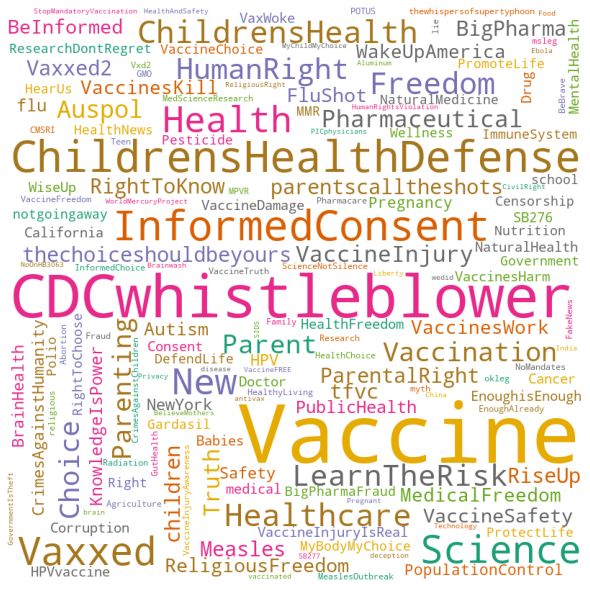

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

data_anti_before_hashtag = extract_hashtags(data_anti_before)
data_anti_before_hashtag['hashtag'] = data_anti_before_hashtag['hashtag'].str[1:]

hashtags = ''
for index, row in data_anti_before_hashtag.iterrows():
     
    # typecaste each val to string
    word = row['hashtag']
     
    # Converts each token into lowercase
    for i in range(row['counts']):
      hashtags += (word+" ")     

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations=False, colormap = "Dark2",
                min_font_size = 10).generate(hashtags)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

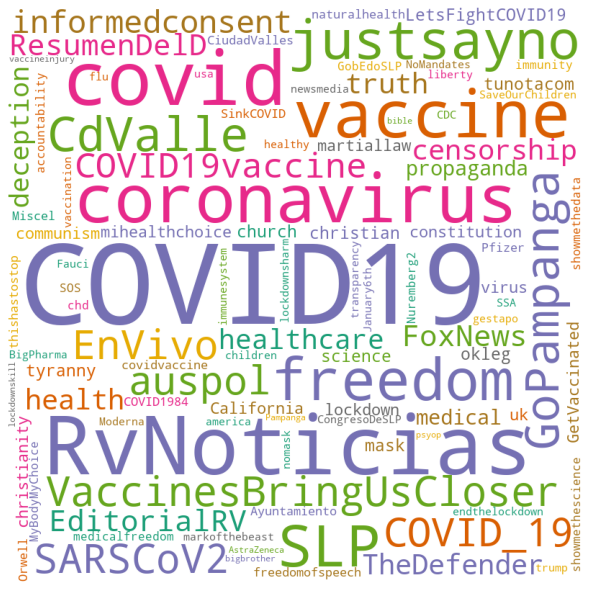

In [ ]:
data_anti_after_hashtag = extract_hashtags(data_anti_after)
data_anti_after_hashtag['hashtag'] = data_anti_after_hashtag['hashtag'].str[1:]

hashtags = ''
for index, row in data_anti_after_hashtag.iterrows():
     
    # typecaste each val to string
    word = row['hashtag']
     
    # Converts each token into lowercase
    for i in range(row['counts']):
      hashtags += (word+" ")     

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations=False, colormap = "Dark2",
                min_font_size = 10).generate(hashtags)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

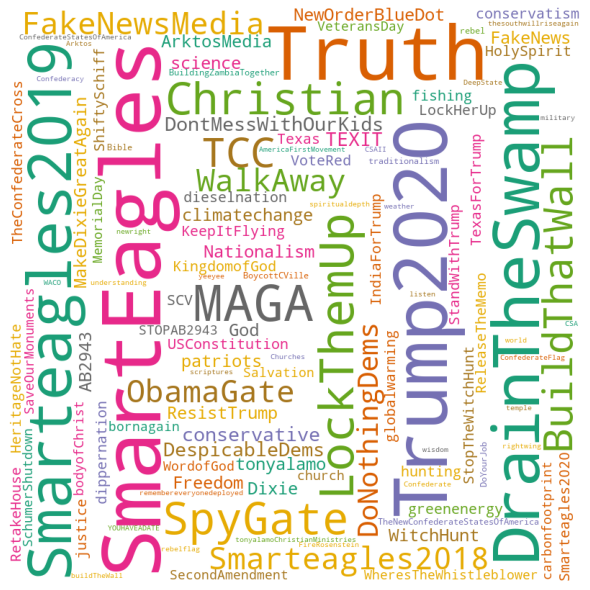

In [ ]:
data_alt_before_hashtag = extract_hashtags(data_alt_before)
data_alt_before_hashtag['hashtag'] = data_alt_before_hashtag['hashtag'].str[1:]

hashtags = ''
for index, row in data_alt_before_hashtag.iterrows():
     
    # typecaste each val to string
    word = row['hashtag']
     
    # Converts each token into lowercase
    for i in range(row['counts']):
      hashtags += (word+" ")     

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations=False, colormap = "Dark2",
                min_font_size = 10).generate(hashtags)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

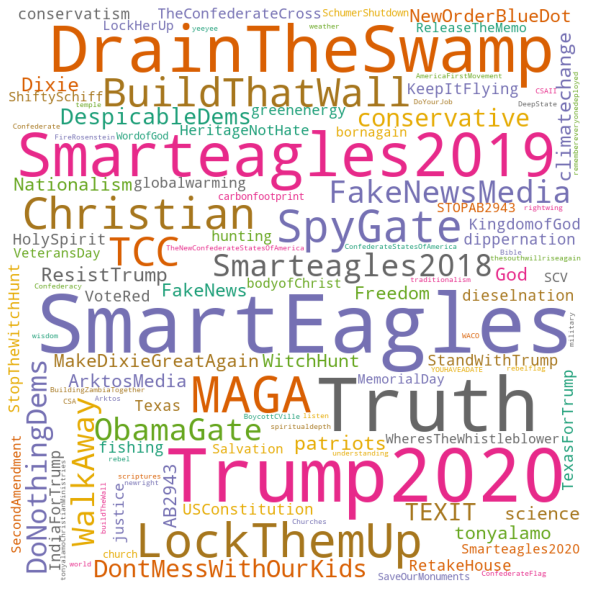

In [ ]:
data_alt_after_hashtag = extract_hashtags(data_alt_before)
data_alt_after_hashtag['hashtag'] = data_alt_after_hashtag['hashtag'].str[1:]

hashtags = ''
for index, row in data_alt_after_hashtag.iterrows():
     
    # typecaste each val to string
    word = row['hashtag']
     
    # Converts each token into lowercase
    for i in range(row['counts']):
      hashtags += (word+" ")     

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations=False, colormap = "Dark2",
                min_font_size = 10).generate(hashtags)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## pre-processing [Luer]

In [ ]:
def process_text(text):
    combined = ' '.join(text)
    return combined

In [ ]:
# add keywords to stop words
add_stop_words = ['said','say', 'says','news', 'year', 'vaccine', 'covid', 'people','COVID-19','COVID',
                  'coronavirus', 'vaccination', 'vaccinated', 'Pfizer','Pfizer-BioNTech',
                  'Moderna', 'Johnson', 'Johnson’s', 'Janssen','j&j', 'mRNA', 'vaccination',
                  'freedom', 'truth','science', 'government', 'control', 'dictate','personal',
                  'choice', 'hoax', 'flu','www','com', 'http', 'vaccin']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
spanish = nltk.corpus.stopwords.words('spanish')
stop_words = stop_words.union(spanish)

def clean_text(text):
  stemmed_text = []
  porter_stemmer = PorterStemmer()
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'www\.[a-z]+\.at', '', text)
  text = re.sub(r'(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) #remove mentions
  text = re.sub(r'bit.ly/\S+', '', text)
  text = re.sub(r'^((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*$', '', text)
  text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', text)
  result = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  result = result.lower()
  result = result.split()
  result = [r for r in result if r not in stop_words]
  stemmed_result = [porter_stemmer.stem(r) for r in result]
  stemmed_text.append(" ".join(stemmed_result))
  return stemmed_text

In [ ]:
data_alt_before = pd.read_csv('/content/drive/MyDrive/Alt-right-2018-01-01--2020-02-29.csv', delimiter=',')
data_anti_before = pd.read_csv('/content/drive/MyDrive/AVaxxer-2018-01-01--2020-02-29.csv', delimiter=',')
data_alt_after = pd.read_csv('/content/drive/MyDrive/Alt-right-2020-03-01--2021-09-19.csv', delimiter=',')
data_anti_after = pd.read_csv('/content/drive/MyDrive/AVaxxer-2020-03-01--2021-09-19.csv', delimiter=',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,38,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def pre_process(data):
  data['Message'] = data['Message'].drop_duplicates()
  data['Message'] = data['Message'].fillna('')
  text = data['Message'].astype('string').tolist()
  text_combined = process_text(text)
  text_cleaned = clean_text(text_combined)
  return text_cleaned

alt_before = pre_process(data_alt_before)
alt_after = pre_process(data_alt_after)
anti_before = pre_process(data_anti_before)
anti_after = pre_process(data_anti_after)

In [ ]:
import numpy as np
def pre_process_without_combine(data):
  data['Message'] = data['Message'].drop_duplicates()
  data['Message'] = data['Message'].fillna('')
  data['Message'] = data['Message'].astype('string')
  data['Message'] = data['Message'].apply(clean_text)
  data['Message'] = data['Message'].apply(np.squeeze)
  data = data[data['Message']!=""]
  
  return pd.DataFrame(data['Message'])

alt_before = pre_process_without_combine(data_alt_before)
alt_after = pre_process_without_combine(data_alt_after)
anti_before = pre_process_without_combine(data_anti_before)
anti_after = pre_process_without_combine(data_anti_after)

In [ ]:
alt_before.to_csv('alt_before_cleaned.csv', index = False)
alt_after.to_csv('alt_after_cleaned.csv', index = False)
anti_before.to_csv('anti_before_cleaned.csv', index = False)
anti_after.to_csv('anti_after_cleaned.csv', index = False)

## LDA for each corpus [Luer]

In [ ]:
def LDA(ls):
  df = pd.DataFrame(ls, columns=['text'])
  cv = CountVectorizer(stop_words=stop_words)
  data_cv = cv.fit_transform(df.text)
  data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
  data_dtm.index = df.index
  tdm = data_dtm.transpose()
  sparse_counts = scipy.sparse.csr_matrix(tdm)
  corpus = matutils.Sparse2Corpus(sparse_counts)

  id2word = dict((v, k) for k, v in cv.vocabulary_.items())
  lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=80)
  for idx, topic in lda.print_topics(-1):
      print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
#alt-before
LDA(alt_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.008*"presid" + 0.006*"zambia" + 0.005*"nation" + 0.005*"trump" + 0.005*"state" + 0.005*"countri" + 0.003*"time" + 0.003*"mr" + 0.003*"polit" + 0.003*"parti"
Topic: 1 
Words: 0.000*"presid" + 0.000*"zambia" + 0.000*"polit" + 0.000*"state" + 0.000*"trump" + 0.000*"nation" + 0.000*"countri" + 0.000*"mr" + 0.000*"parti" + 0.000*"time"


In [ ]:
#alt-after
LDA(alt_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.000*"podcast" + 0.000*"presid" + 0.000*"conserv" + 0.000*"daili" + 0.000*"like" + 0.000*"biden" + 0.000*"trump" + 0.000*"support" + 0.000*"zambia" + 0.000*"new"
Topic: 1 
Words: 0.013*"podcast" + 0.007*"daili" + 0.007*"conserv" + 0.007*"presid" + 0.005*"zambia" + 0.004*"biden" + 0.004*"trump" + 0.004*"state" + 0.004*"new" + 0.004*"nation"


In [ ]:
#anti-before
LDA(anti_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.000*"health" + 0.000*"children" + 0.000*"parent" + 0.000*"time" + 0.000*"medic" + 0.000*"just" + 0.000*"know" + 0.000*"make" + 0.000*"come" + 0.000*"god"
Topic: 1 
Words: 0.006*"health" + 0.006*"children" + 0.004*"time" + 0.004*"state" + 0.003*"parent" + 0.003*"medic" + 0.003*"know" + 0.003*"right" + 0.003*"god" + 0.003*"measl"


In [ ]:
#anti-after
LDA(anti_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.004*"health" + 0.003*"state" + 0.003*"new" + 0.003*"time" + 0.002*"use" + 0.002*"report" + 0.002*"like" + 0.002*"world" + 0.002*"case" + 0.002*"day"
Topic: 1 
Words: 0.000*"new" + 0.000*"health" + 0.000*"time" + 0.000*"state" + 0.000*"right" + 0.000*"just" + 0.000*"death" + 0.000*"case" + 0.000*"medic" + 0.000*"use"


## TF-IDF -> word freq [Luer]

In [ ]:
def pre_process(data):
  data['Message'] = data['Message'].fillna('')
  data['Message'] = data['Message'].astype('string')
  return data[['Message']]

alt_before = pre_process(data_alt_before)
alt_after = pre_process(data_alt_after)
anti_before = pre_process(data_anti_before)
anti_after = pre_process(data_anti_after)

In [ ]:
from sklearn.feature_extraction import text
add_stop_words = ['said','say', 'says','news', 'year', 'vaccine', 'covid', 'people','COVID-19','COVID',
                  'coronavirus', 'vaccination', 'vaccinated', 'Pfizer','Pfizer-BioNTech',
                  'Moderna', 'Johnson', 'Johnson’s', 'Janssen','j&j', 'mRNA', 'vaccination',
                  'freedom', 'truth','science', 'government', 'control', 'dictate','personal',
                  'choice', 'hoax', 'flu', 'www', 'com']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)
data_tfidf = tfidf.fit_transform(alt_before.Message)
feature_names = tfidf.get_feature_names()
max_scores = data_tfidf.toarray().max(0).argsort()
top_10_alt_before = zip(np.array(feature_names)[max_scores[-10:]], max_scores[-10:])
print(list(top_10_alt_before))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('honor', 10401), ('releasefisa', 17812), ('bringing', 3470), ('wow', 23284), ('amazing', 1759), ('listen', 12813), ('amen', 1777), ('amendment', 1782), ('madmaxine', 13137), ('sigh', 19476)]


In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)
data_tfidf = tfidf.fit_transform(alt_after.Message)
feature_names = tfidf.get_feature_names()
max_scores = data_tfidf.toarray().max(0).argsort()
top_10_alt_after = zip(np.array(feature_names)[max_scores[-10:]], max_scores[-10:])
print(list(top_10_alt_after))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


[('necessary', 19462), ('way', 30166), ('blexit', 4530), ('nailedit', 19258), ('watching', 30139), ('bomb', 4667), ('bombshell', 4679), ('watch', 30133), ('warning', 30085), ('surprised', 27224)]


In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)
data_tfidf = tfidf.fit_transform(anti_before.Message)
feature_names = tfidf.get_feature_names()
max_scores = data_tfidf.toarray().max(0).argsort()
top_10_anti_before = zip(np.array(feature_names)[max_scores[-10:]], max_scores[-10:])
print(list(top_10_anti_before))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
tfidf = TfidfVectorizer(stop_words=stop_words)
data_tfidf = tfidf.fit_transform(anti_after.Message)
feature_names = tfidf.get_feature_names()
max_scores = data_tfidf.toarray().max(0).argsort()
top_10_anti_after = zip(np.array(feature_names)[max_scores[-10:]], max_scores[-10:])
print(list(top_10_anti_after))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


## nouns

In [ ]:
from nltk import word_tokenize, pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

def LDA_nouns(ls):
  df = pd.DataFrame(ls, columns=['text'])
  df = pd.DataFrame(df.text.apply(nouns))
  cv = CountVectorizer(stop_words=stop_words)
  data_cv = cv.fit_transform(df.text)
  data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
  data_dtm.index = df.index
  tdm = data_dtm.transpose()
  sparse_counts = scipy.sparse.csr_matrix(tdm)
  corpus = matutils.Sparse2Corpus(sparse_counts)

  id2word = dict((v, k) for k, v in cv.vocabulary_.items())
  lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=80)
  for idx, topic in lda.print_topics(-1):
      print('Topic: {} \nWords: {}'.format(idx, topic))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
LDA_nouns(alt_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.000*"presid" + 0.000*"zambia" + 0.000*"trump" + 0.000*"state" + 0.000*"countri" + 0.000*"time" + 0.000*"nation" + 0.000*"day" + 0.000*"media" + 0.000*"report"
Topic: 1 
Words: 0.011*"presid" + 0.008*"zambia" + 0.008*"nation" + 0.007*"state" + 0.006*"trump" + 0.006*"countri" + 0.005*"time" + 0.004*"mr" + 0.004*"media" + 0.004*"day"


In [ ]:
#alt-after
LDA(alt_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.013*"podcast" + 0.007*"daili" + 0.007*"conserv" + 0.007*"presid" + 0.005*"zambia" + 0.004*"biden" + 0.004*"trump" + 0.004*"state" + 0.004*"new" + 0.004*"nation"
Topic: 1 
Words: 0.000*"podcast" + 0.000*"conserv" + 0.000*"daili" + 0.000*"presid" + 0.000*"biden" + 0.000*"ly" + 0.000*"nation" + 0.000*"zambia" + 0.000*"trump" + 0.000*"make"


In [ ]:
#anti-before
LDA(anti_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.006*"health" + 0.006*"children" + 0.004*"time" + 0.004*"state" + 0.003*"parent" + 0.003*"medic" + 0.003*"know" + 0.003*"right" + 0.003*"god" + 0.003*"measl"
Topic: 1 
Words: 0.000*"children" + 0.000*"health" + 0.000*"parent" + 0.000*"time" + 0.000*"make" + 0.000*"state" + 0.000*"medic" + 0.000*"know" + 0.000*"gov" + 0.000*"god"


In [ ]:
#anti-after
LDA(anti_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.004*"health" + 0.003*"state" + 0.003*"new" + 0.003*"time" + 0.002*"use" + 0.002*"report" + 0.002*"like" + 0.002*"world" + 0.002*"case" + 0.002*"day"
Topic: 1 
Words: 0.000*"health" + 0.000*"new" + 0.000*"state" + 0.000*"time" + 0.000*"report" + 0.000*"use" + 0.000*"like" + 0.000*"case" + 0.000*"come" + 0.000*"medic"


## adjectives

In [ ]:
def adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

def LDA_adj(ls):
  df = pd.DataFrame(ls, columns=['text'])
  df = pd.DataFrame(df.text.apply(adj))
  cv = CountVectorizer(stop_words=stop_words)
  data_cv = cv.fit_transform(df.text)
  data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
  data_dtm.index = df.index
  tdm = data_dtm.transpose()
  sparse_counts = scipy.sparse.csr_matrix(tdm)
  corpus = matutils.Sparse2Corpus(sparse_counts)

  id2word = dict((v, k) for k, v in cv.vocabulary_.items())
  lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=80)
  for idx, topic in lda.print_topics(-1):
      print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
LDA_nouns(alt_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.011*"presid" + 0.008*"zambia" + 0.008*"nation" + 0.007*"state" + 0.006*"trump" + 0.006*"countri" + 0.005*"time" + 0.004*"mr" + 0.004*"media" + 0.004*"day"
Topic: 1 
Words: 0.000*"presid" + 0.000*"zambia" + 0.000*"state" + 0.000*"nation" + 0.000*"trump" + 0.000*"media" + 0.000*"support" + 0.000*"time" + 0.000*"polit" + 0.000*"world"


In [ ]:
#alt-after
LDA(alt_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.013*"podcast" + 0.007*"daili" + 0.007*"conserv" + 0.007*"presid" + 0.005*"zambia" + 0.004*"biden" + 0.004*"trump" + 0.004*"state" + 0.004*"new" + 0.004*"nation"
Topic: 1 
Words: 0.000*"podcast" + 0.000*"daili" + 0.000*"conserv" + 0.000*"zambia" + 0.000*"presid" + 0.000*"biden" + 0.000*"new" + 0.000*"state" + 0.000*"nation" + 0.000*"ly"


In [ ]:
#anti-before
LDA(anti_before)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.000*"health" + 0.000*"know" + 0.000*"state" + 0.000*"children" + 0.000*"new" + 0.000*"org" + 0.000*"time" + 0.000*"medic" + 0.000*"day" + 0.000*"inform"
Topic: 1 
Words: 0.006*"health" + 0.006*"children" + 0.004*"time" + 0.004*"state" + 0.003*"parent" + 0.003*"medic" + 0.003*"know" + 0.003*"right" + 0.003*"god" + 0.003*"measl"


In [ ]:
#anti-after
LDA(anti_after)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['19', 'biontech', 'janssen', 'johnson', 'moderna', 'mrna', 'pfizer'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Topic: 0 
Words: 0.000*"health" + 0.000*"new" + 0.000*"like" + 0.000*"time" + 0.000*"use" + 0.000*"state" + 0.000*"come" + 0.000*"know" + 0.000*"live" + 0.000*"case"
Topic: 1 
Words: 0.004*"health" + 0.003*"state" + 0.003*"new" + 0.003*"time" + 0.002*"use" + 0.002*"report" + 0.002*"like" + 0.002*"world" + 0.002*"case" + 0.002*"day"
